In [1]:
# 데이터 로드
# sns.get_dataset_names() 실행하여 나온 리스트 중에서 데이터 고르시거나, kaggle에서 찾으신 후 pandas로 로드하세요! 
# kaggle에서 찾으실 경우 data = pd.read_csv('파일명',engine='python')
import pandas as pd
import seaborn as sns

peng = sns.load_dataset('penguins', engine='python')
peng.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [2]:
#######################################################################################################################################
#---------------------------------------------------- EDA (탐색적 데이터 분석) -------------------------------------------------------#
########################################################################################################################################

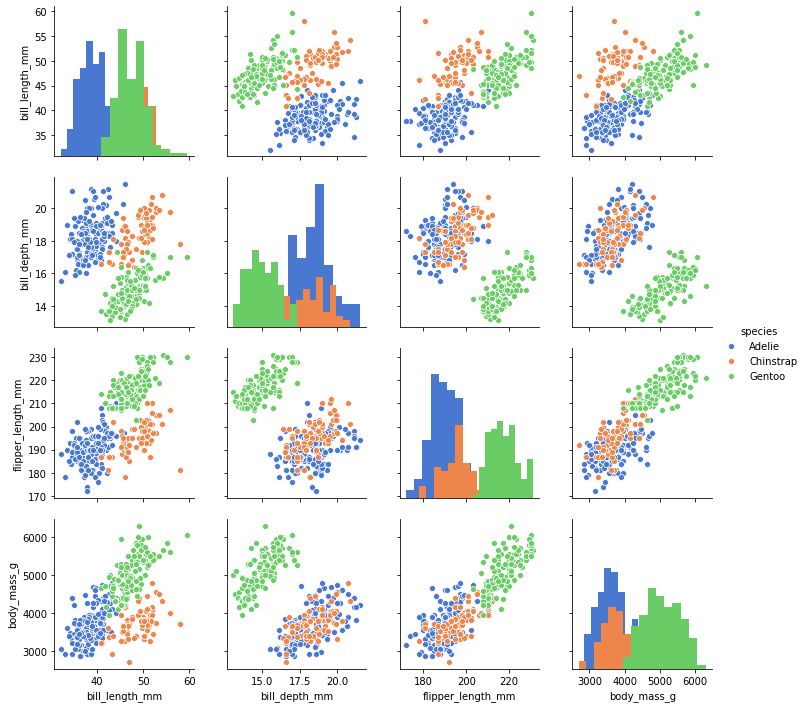

In [3]:
# 분포 관찰
# 순서대로 데이터, 색 구분 기준, 색 조합, 대각선 plot 유형 
sns.pairplot(peng, hue="species", palette="muted", diag_kind='hist')

In [4]:
# 사용할 열만 남기고 제거할게요
df = peng.drop(['species','island','sex'],axis=1)
df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0


In [5]:
# 결측치 개수 확인
df.isnull().sum()

bill_length_mm       2
bill_depth_mm        2
flipper_length_mm    2
body_mass_g          2
dtype: int64

In [6]:
# 결측치 제거
df = df.dropna()
df.isnull().sum()

bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
dtype: int64

In [7]:
# 이상치 제거 method = z-score
import numpy as np
df.loc[:,'out'] = 0
for c in df.columns[:-1]:
    z = (df[c] - df[c].mean()) / df[c].std(ddof=0) 
    thr = 2.58
    
    df.loc[:,'out'] = np.where(abs(z)>=thr,1,0)

print(f'이상치가 있는 관측치의 개수: {df.out.sum()}')

df1 = df.drop(df[df['out']==1].index)

이상치가 있는 관측치의 개수: 1


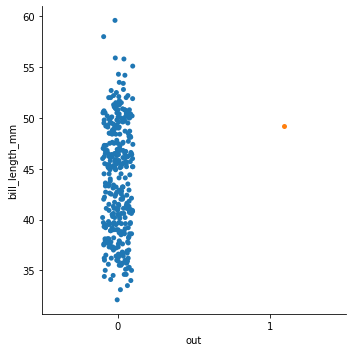

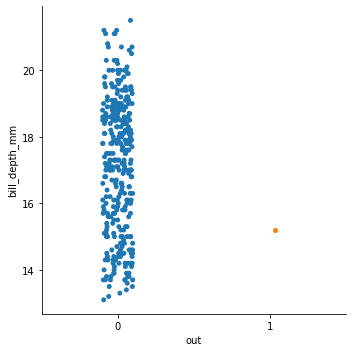

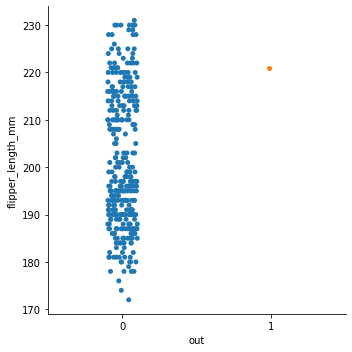

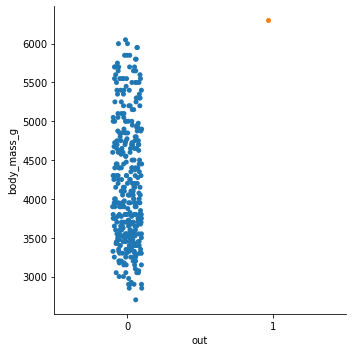

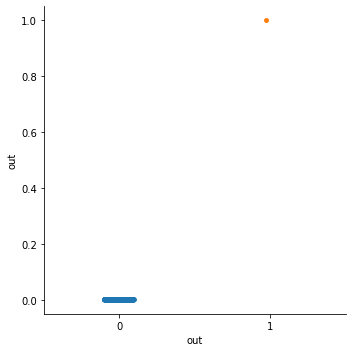

In [8]:
# 이상치 plot
for i in range(len(df.columns)):
    sns.catplot(x='out',y=df.columns[i],data=df)

In [9]:
# 이상치 제거 method = MAD
df.loc[:,'out'] = 0
for c in df.columns:
    median = df[c].median()
    median_abs_std = np.median([abs(v-median) for v in df.loc[:,c]])
    
    thr = 3.5
    z = 0.6745*(df.loc[:,c] - median)/median_abs_std
    
    df.loc[:,'out'] = np.where(abs(z)>=thr,1,0)

print(f'이상치가 있는 관측치의 개수: {df.out.sum()}')

df2 = df.drop(df[df['out']==1].index)

이상치가 있는 관측치의 개수: 0


In [10]:
# 이상치 제거 method = Tukey
df.loc[:,'out'] = 0
for c in df.columns:
    q1, q3  = np.percentile(df.loc[:,c], [25, 75])
    iqr = q3 - q1
    upper = q3 + (iqr * 1.5)
    lower = q1 - (iqr * 1.5)
    
    df.loc[:,'out'] = np.where((df.loc[:,c]>upper)|(df.loc[:,c]<lower),1,0)
    
print(f'이상치가 있는 관측치의 개수: {df.out.sum()}')

df3 = df.drop(df[df['out']==1].index)

이상치가 있는 관측치의 개수: 0


In [11]:
# 저는 z-score로 이상치를 제거한 데이터를 사용하겠습니다
df = df1
df.drop('out',axis=1,inplace=True)
df.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


In [12]:
#######################################################################################################################################
#---------------------------------------------------------- Clustering----------------------------------------------------------------#
########################################################################################################################################

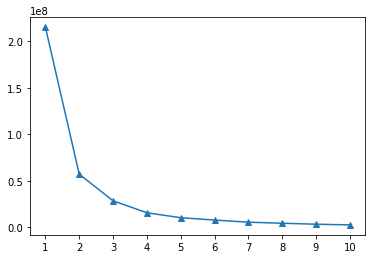

In [13]:
# Elbow meghod: k-means clustering에서 k의 값(군집수) 결정
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# elbow point를 찾을 수 있는 plot을 그려주는 함수
# 그냥 함수 안에 데이터프레임 넣으시면 돼요!
def elbow(df):
    sse = []
    for i in range(1,11):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(df.values)
        sse.append(kmeans.inertia_)
    plt.plot(range(1,11), sse, marker='^')
    plt.xticks(list(range(1,11)))
    
# y값의 감소율이 급격히 줄어드는 지점의 x값을 k로 합니다. 아래의 경우 k=3. 
elbow(df) 

In [14]:
# 세 개의 군집으로 클러스터링 
kmeans = KMeans(n_clusters=3)
kmeans.fit(df.values)

# cluster_id는 각 데이터가 속하는 군집번호 
df['cluster_id'] = kmeans.labels_
df.tail()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,cluster_id
338,47.2,13.7,214.0,4925.0,0
340,46.8,14.3,215.0,4850.0,2
341,50.4,15.7,222.0,5750.0,0
342,45.2,14.8,212.0,5200.0,0
343,49.9,16.1,213.0,5400.0,0


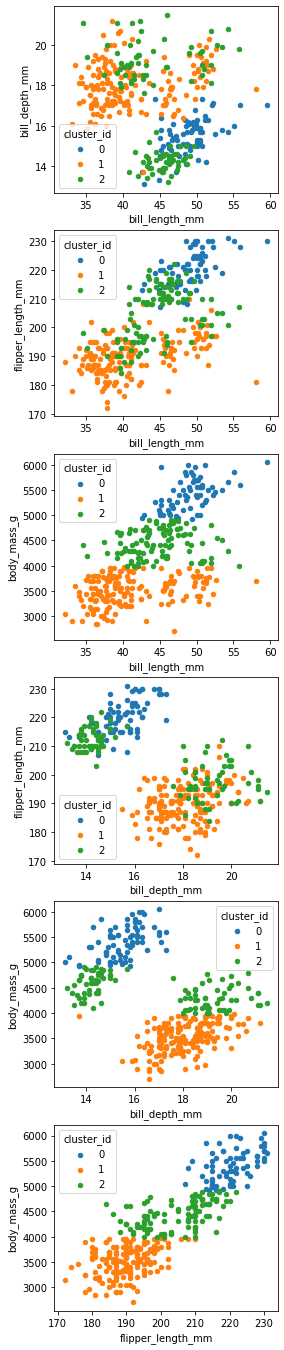

In [15]:
# plot1
# 군집은 고차원에서 만들어지지만 시각화가 어렵기 때문에 2차원 평면에서 시각화해보겠습니다
import matplotlib.pyplot as plt

# n: cluster_id를 제외한 열의 수
n = len(df.columns)-1

# m: 열들의 조합 수 
m = n*(n-1)/2

# plot이 그려질 바탕의 크기 결정 
plt.figure(figsize=(4,4*m))
cnt = 1 

for i in range(n):  #x축
    for j in range(i+1,n):    #y축
        plt.subplot(int(m),1,cnt)   #subplot 위치. m행 1열 중 cnt번째 
        cnt += 1
        for k in range(len(np.unique(df.cluster_id))): # 군집수(k)가 같은 것끼리 그림. 범례를 표시하기 위해서. 
            plt.scatter(df.columns[i],df.columns[j], data=df[df['cluster_id']==k],label=k,s=20)
            plt.xlabel(df.columns[i])  # x축 이름
            plt.ylabel(df.columns[j])  # y축 이름
            plt.legend(title='cluster_id',loc='best')  # 범례 

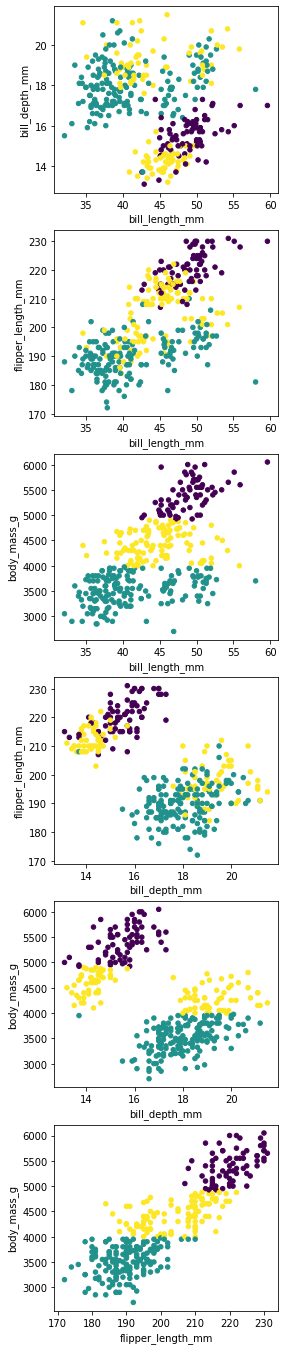

In [16]:
# plot 1-2
# 범례 표시 안 하면 좀 더 간단해짐
plt.figure(figsize=(4,4*m))
cnt = 1 

for i in range(n):  #x축
    for j in range(i+1,n):    #y축
        plt.subplot(int(m),1,cnt)   #subplot 위치. m행 1열 중 cnt번째 
        cnt += 1
        plt.scatter(df.iloc[:,i],df.iloc[:,j],c=df.cluster_id,s=20)
        plt.xlabel(df.columns[i])  # x축 이름
        plt.ylabel(df.columns[j])  # y축 이름

<Figure size 288x1728 with 0 Axes>

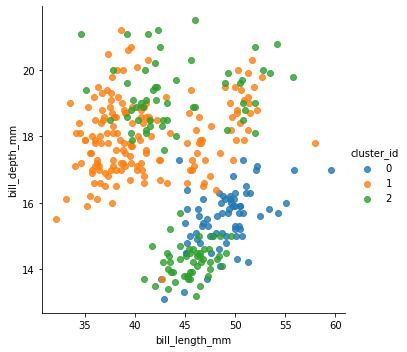

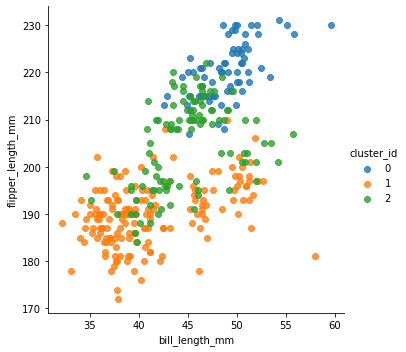

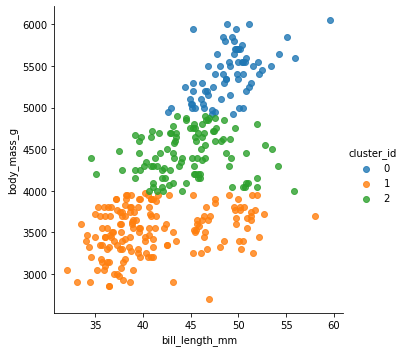

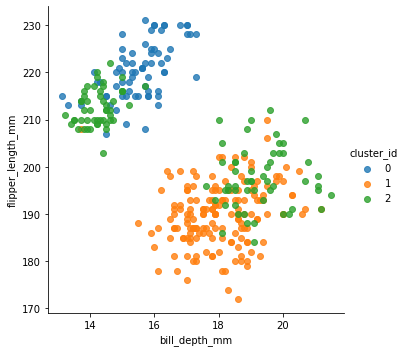

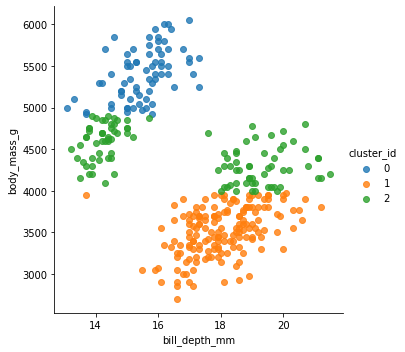

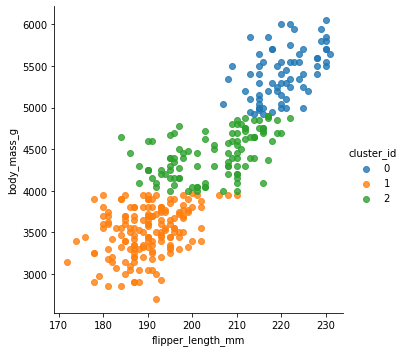

In [17]:
# plot2 seaborn을 이용해서 쉽게 그릴 수 있어요
import seaborn as sns

plt.figure(figsize=(4,4*m))
cnt = 1 

for i in range(n):  
    for j in range(i+1,n):    
        sns.lmplot(df.columns[i],df.columns[j], data=df, hue='cluster_id', fit_reg=False)

In [18]:
#######################################################################################################################################
#---------------------------------------------------------- Classification------------------------------------------------------------#
########################################################################################################################################

In [19]:
# 여기부터는 iris 데이터를 사용하겠습니다.
iris = sns.load_dataset('iris',engine='python')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [20]:
# 결측치 없음
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [21]:
# 이상치 없음
dff = iris.drop('species',axis=1)
dff.loc[:,'out'] = 0
for c in dff.columns[:-1]:
    z = (dff[c] - dff[c].mean()) / dff[c].std(ddof=0) 
    thr = 2.58
    
    dff.loc[:,'out'] = np.where(abs(z)>=thr,1,0)

print(f'이상치가 있는 관측치의 개수: {dff.out.sum()}')

이상치가 있는 관측치의 개수: 0


In [22]:
# feature variable: x
x = iris.drop('species',axis=1)
x.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [23]:
# target variable: y 
# 붓꽃의 종을 분류하는 모델을 만들게요

y = iris['species']
print(f'범주는 {np.unique(y)}로 총 {len(np.unique(y))}개입니다')

범주는 ['setosa' 'versicolor' 'virginica']로 총 3개입니다


In [24]:
# 문자열 데이터를 수치형으로 변환
# 안 하면 나중에 에러날 수 있음 ㅜㅜ 
from sklearn.preprocessing import LabelEncoder
classle = LabelEncoder()
y = classle.fit_transform(y.values)

print(f'범주는 {np.unique(y)}로 총 {len(np.unique(y))}개입니다')

범주는 [0 1 2]로 총 3개입니다


In [25]:
# 데이터를 학습용(training data)과 성능평가용(test data)으로 나눌게요
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.4, random_state=1, stratify=y)

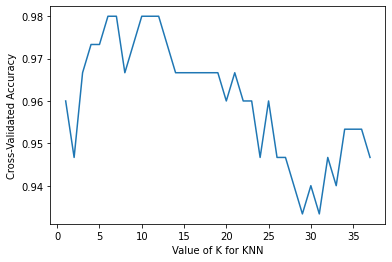

In [26]:
### classificaton = KNN
# k 결정
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from math import ceil
k_scores = []

# k를 결정하는 데 사용하는 함수
def find_k(x,y):
    for k in range(1,ceil(len(x)*1/4)):
        knn = KNeighborsClassifier(k)
        scores = cross_val_score(knn, x, y, cv=5, scoring='accuracy')
        k_scores.append(scores.mean())
    plt.plot(range(1,ceil(len(x)*1/4)),k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-Validated Accuracy')
    plt.xticks(list(range(0,ceil(len(x)*1/4),5)))
    
# y값이 클수록 좋습니다. 여기서는 11을 사용하면 될 듯 하네요 
find_k(x,y)

In [27]:
# 학습
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=11)

In [28]:
# 예측
y_test_pred = knn.predict(x_test)
print(y_test_pred[:37])

[0 2 0 1 2 1 1 2 2 0 2 0 2 2 1 1 2 1 2 1 0 0 2 0 1 1 2 0 2 0 0 1 1 2 2 0 0]


In [29]:
# 평가
from sklearn.metrics import accuracy_score
print('accurcy ::', accuracy_score(y_test,y_test_pred))

accurcy :: 0.9833333333333333


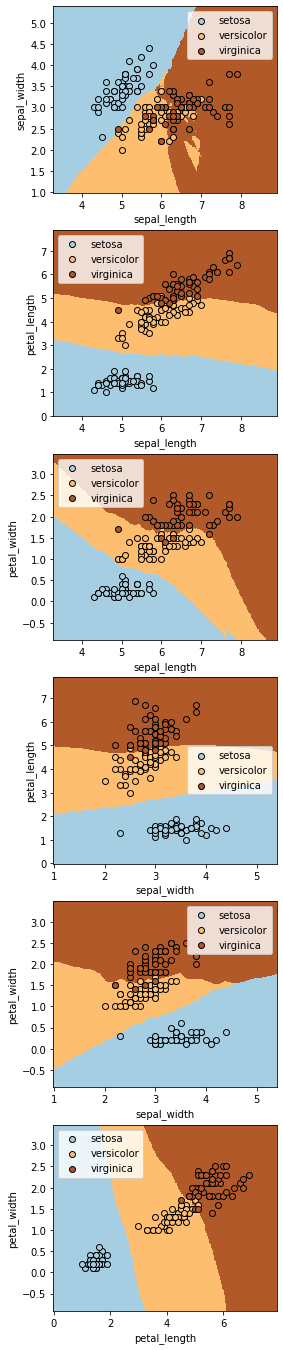

In [30]:
# 2차원 설명변수를 이용해 분류한 후 시각화해볼게요
# dataset을 training data와 test data로 나누지 않고 모두 training에 사용한다고 가정
n=len(x.columns)  # 사용 가능한 변수의 개수
m=n*(n-1)/2    # 변수 조합 수
cnt=1

plt.figure(figsize=(4,4*m))
plt.set_cmap(plt.cm.Paired)
c_lst = [plt.cm.Paired(a) for a in np.linspace(0,1,len(np.unique(y)))]
names = classle.inverse_transform(np.unique(y))

for i in range(n):
    for j in range(i+1,n):
        x_min, x_max = x.iloc[:,i].min()-1, x.iloc[:,i].max()+1
        y_min, y_max = x.iloc[:,j].min()-1, x.iloc[:,j].max()+1
        
        knn.fit(x.iloc[:,[i,j]], y)
        
        xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02), np.arange(y_min,y_max,0.02))
        z = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)    
        
        plt.subplot(int(m),1,cnt)
        plt.pcolormesh(xx,yy,z,shading='auto')
        
        for k in np.unique(y):
            plt.scatter(x.columns[i],x.columns[j], color=c_lst[k],
                        label=names[k],data=x[y==k], edgecolor='black')
        
        plt.xlabel(x.columns[i])
        plt.ylabel(x.columns[j])
        plt.legend()
        
        cnt+=1

In [31]:
### classificaton = SVM 
import numpy as np
from sklearn import svm

# 학습
clf = svm.SVC(kernel='linear')
clf.fit(x_train,y_train)

# 예측
y_test_pred = clf.predict(x_test)
print(y_test_pred[:5])

# 평가
print('accurcy ::', accuracy_score(y_test,y_test_pred))

[0 2 0 1 2]
accurcy :: 1.0


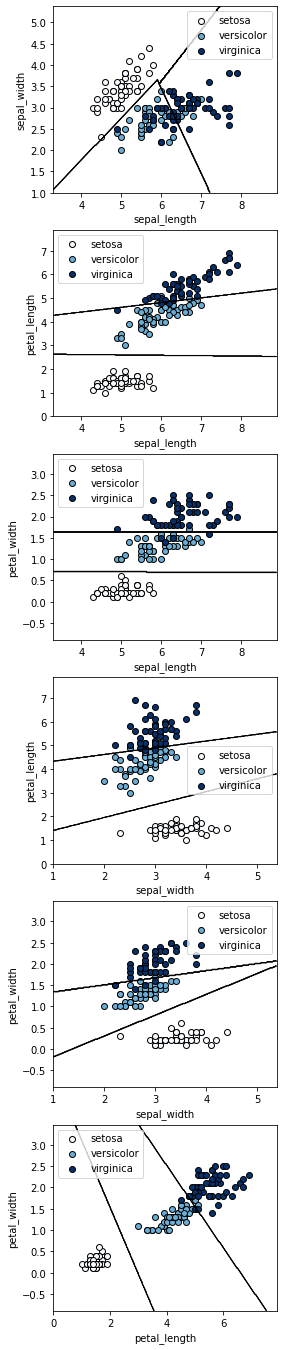

In [32]:
# 2차원 설명변수를 이용해 분류하는 경우 plotting
# data를 나누지 않고 모두 training에 사용한다고 가정

n=len(x.columns)
m=n*(n-1)/2
cnt=1

plt.figure(figsize=(4,4*m))
plt.set_cmap(plt.cm.Blues)
c_lst = [plt.cm.Blues(a) for a in np.linspace(0,1,len(np.unique(y)))]
names = classle.inverse_transform(np.unique(y))

for i in range(n):
    for j in range(i+1,n):
        x_min, x_max = x.iloc[:,i].min()-1, x.iloc[:,i].max()+1
        y_min, y_max = x.iloc[:,j].min()-1, x.iloc[:,j].max()+1
        
        clf.fit(x.iloc[:,[i,j]], y)
        
        xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02), np.arange(y_min,y_max,0.02))
        z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)    
        
        plt.subplot(int(m),1,cnt)
        plt.contour(xx,yy,z,colors='k',linewidths=0.8)
        
        for k in np.unique(y):
            plt.scatter(x.columns[i],x.columns[j], color=c_lst[k],
                        label=names[k],data=x[y==k], edgecolor='black')
        
        plt.xlabel(x.columns[i])
        plt.ylabel(x.columns[j])
        plt.legend()
        
        cnt+=1

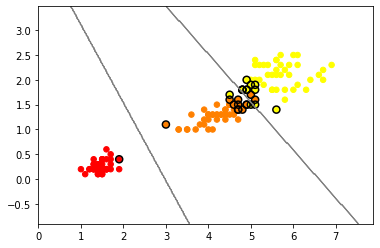

In [33]:
# support vector 표시
x_min, x_max = x.iloc[:,2].min()-1, x.iloc[:,2].max()+1
y_min, y_max = x.iloc[:,3].min()-1, x.iloc[:,3].max()+1
        
clf.fit(x.iloc[:,[2,3]], y)
        
xx, yy = np.meshgrid(np.arange(x_min,x_max,0.02), np.arange(y_min,y_max,0.02))
z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape) 

plt.scatter(x.iloc[:,2], x.iloc[:,3], c=y, s=30, cmap=plt.cm.autumn)
plt.contour(xx,yy,z,colors='grey',linewidths=0.8)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50, facecolor='none', edgecolor='black',linewidths=1.5)

In [34]:
#######################################################################################################################################
#------------------------------------------------------------ Regression --------------------------------------------------------------#
########################################################################################################################################

In [35]:
# 펭귄 데이터를 사용할게요
df = peng.iloc[df.index,:]
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [36]:
df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,341.000000,341.000000,341.000000,341.000000
mean,43.906452,17.156891,200.856305,4195.601173
std,5.460087,1.974854,14.040064,795.006755
min,32.100000,13.100000,172.000000,2700.000000
25%,39.200000,15.600000,190.000000,3550.000000
50%,44.400000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6050.000000


<AxesSubplot:>

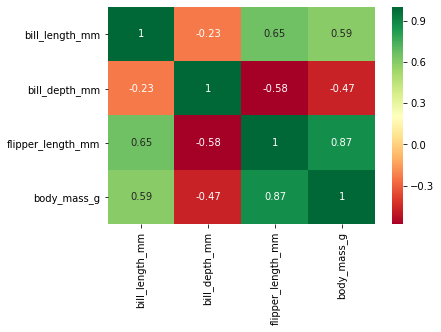

In [37]:
# 상관계수
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

In [38]:
# 선형 회귀분석의 표준 가정
# 1. 독립 변수와 종속 변수 간의 선형성
# 2. 잔차의 독립성 
# 3. 잔차의 등분산성 
# 4. 잔차의 정규성
# 이때 독립변수간의 독립성은 회귀모형의 성능을 위해 권장된다. 

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


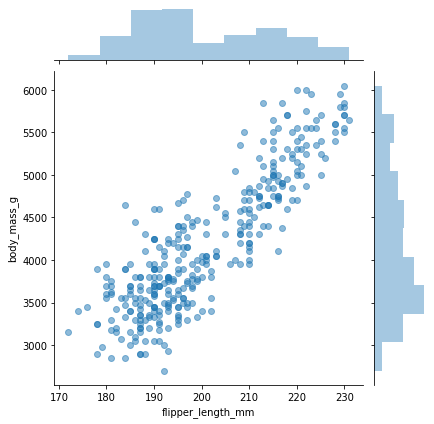

In [39]:
# 펭귄의 몸무게를 날개 길이를 이용해 예측하는 단순회귀분석을 하겠습니다
# 단순선형회귀분석에서는 선형성만 확인하면 돼요! 
# 1.선형성 - 보통 산점도 그래프를 그려서 육안으로 체크해요
x,y = df['flipper_length_mm'], df['body_mass_g']
sns.jointplot(x,y, kind='scatter', joint_kws={'alpha':0.5}, data=df)

In [40]:
# 하지만 이번에는 좀 더 정확하게 피어슨 상관계수 검정을 실시하겠습니다
from scipy import stats
corr = stats.pearsonr(x,y)
corr  # 순서대로 상관계수, p-value입니다. 이때  p-vlaue < 0.05면 선형관계를 가지고 있다고 판단해요.

(0.871622059754239, 5.319741834302539e-107)

In [41]:
# 회귀분석 
from statsmodels.formula.api import ols

reg = ols('body_mass_g ~ flipper_length_mm', data=df).fit()
reg.summary() # coef 를 보시면 됩니다. 
# 분석 결과 body_mass_g = -5717.6338 + 49.3549*flipper_length_mm 의 관계를 얻었습니다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1072.
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          5.32e-107
Time:                        03:19:31   Log-Likelihood:                -2517.5
No. Observations:                 341   AIC:                             5039.
Df Residuals:                     339   BIC:                             5047.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -5717.6338    303.527    -18.837      0.000   -6314.667   -5120.601
flipper_length_mm    49.3549      1.507     32.740      0.000      46.390      52.320
==============================================================================
Omnibus:                        4.398   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.111   Jarque-Bera (JB):                4.375
Skew:                           0.277   Prob(JB):                        0.112
Kurtosis:                       2.971   Cond. No.                     2.89e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'body_mass_g')

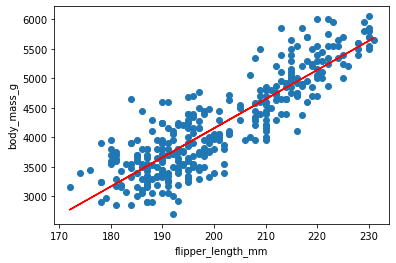

In [42]:
# 실제 분포와, 예측한 값을 함께 그려볼게요
plt.scatter(x,y)   # 실제 데이터 산점도 그래프
plt.plot(x,reg.predict(),color='red')  # 예측값 
plt.xlabel('flipper_length_mm')
plt.ylabel('body_mass_g')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<AxesSubplot:xlabel='flipper_length_mm', ylabel='body_mass_g'>

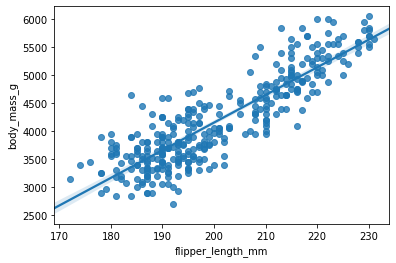

In [43]:
# seaborn에서 제공하는 기능 
sns.regplot(x,y)

In [44]:
# 다중 선형 회귀분석
# 먼저 선형 회귀분석의 네 가지 가정 중 1.선형성을 만족하는지 보겠습니다
# 선형성 검정
for i in range(2,5):
    corr = stats.pearsonr(df.iloc[:,i],df.iloc[:,5])
    print(corr)
# 모두 p-value < 0.05로 선형성 가정 만족 

(0.594494988281837, 5.755163990407807e-34)
(-0.4697332666957498, 4.064508852744197e-20)
(0.871622059754239, 5.319741834302539e-107)


In [45]:
# body_mass_g를 종속변수로 부리 길이/깊이, 날개 길이를 독립변수로 두고 다중회귀분석을 해볼게요
reg2 = ols('body_mass_g ~ bill_length_mm+bill_depth_mm+flipper_length_mm',data=df).fit()
reg2.summary()
# 분석 결과 body_mass_g = -6376.2915 + 4.0901*bill_length_mm + 20.4815*bill_depth_mm + 49.9905*flipper_length_mm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     360.3
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          9.24e-105
Time:                        03:19:32   Log-Likelihood:                -2515.7
No. Observations:                 341   AIC:                             5039.
Df Residuals:                     337   BIC:                             5055.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -6376.2915    555.890    -11.470      0.000   -7469.744   -5282.839
bill_length_mm        4.0901      5.274      0.776      0.439      -6.283      14.464
bill_depth_mm        20.4815     13.552      1.511      0.132      -6.176      47.139
flipper_length_mm    49.9905      2.453     20.377      0.000      45.165      54.816
==============================================================================
Omnibus:                        3.949   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.850
Skew:                           0.260   Prob(JB):                        0.146
Kurtosis:                       3.014   Cond. No.                     5.45e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# 2.독립성 3.등분산성 4.정규성 가정 만족하는지 확인
fitted = reg2.predict()   # 추정값; 위에서 구한 식에 독립변수의 값을 대입해 구해 예측한 종속변수 값
residual = df['body_mass_g'] - fitted  # 잔차; 실제 종속변수 값 - 추정값

In [47]:
# 2. 독립성 검정 - Durbin-Watson test
from statsmodels.stats.stattools import durbin_watson

durbin_watson(residual) # 사실 summary에도 durbin-watson 통계량이 구해져 있어요ㅎ
# 일반적으로 1.5~2.5 사이일 때 자기상관(autocorrelation)이 없다, 잔차가 독립성을 만족한다고 해석합니다.
# 1.5 미만일 때 양의 자기상관을, 2.5 초과일 때 음의 자기상관을 가진다고 얘기해요.  

2.0119460851227764

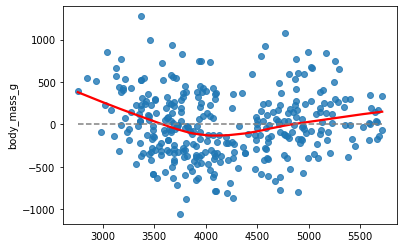

In [48]:
# 3. 등분산성 검정 - 육안으로 확인, 빨간 실선이 점선에서 크게 벗어나면 등분산성 X
sns.regplot(fitted, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([fitted.min(), fitted.max()], [0, 0], '--', color='grey')   

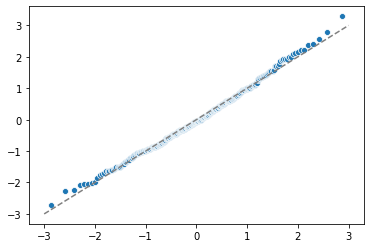

In [50]:
# 4. 정규성 검정 - 육안으로 확인, 점들이 45도 직선 모양으로 찍히면 정규성 따른다고 판단함. 
import scipy
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

In [51]:
# 4. 정규성 검정, Shapiro test, p-value가 0.05보다 작으면 정규성을 만족하지 않는다고 판단함.
stats.shapiro(residual)   # p-value = 0.32 > 0.05로 정규성 만족 

(0.9949041604995728, 0.32171300053596497)

In [52]:
# 4. 정규성 검정, Jacque-Bera(JB) test, p-value >= 0.05면 정규성 만족
# reg2.summary() 에 값 있음 
# Jarque-Bera (JB):	3.850   # 통계량 값, 자유도 2의 카이제곱 분포를 따름 
# Prob(JB):	0.146    # p-value, 0.05보다 크므로 정규성 만족 
from scipy.stats import chi2
rv = chi2(df=2) # df = Degree of Freedom, 자유도
round(1-rv.cdf(3.850),3)  

0.146

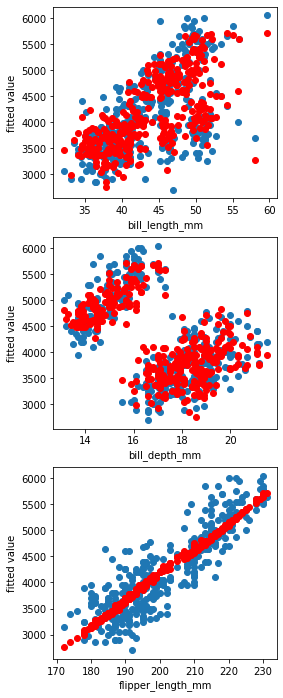

In [53]:
# plot을 그려 추정값들의 분포를 확인하겠습니다.
plt.figure(figsize=(4,12))
cnt=1
for i in range(2,5):
    plt.subplot(3,1,cnt)
    plt.scatter(df.iloc[:,i],df['body_mass_g'])
    plt.scatter(df.iloc[:,i],fitted,color='red')
    plt.xlabel(df.columns[i])
    plt.ylabel('fitted value')
    cnt+=1

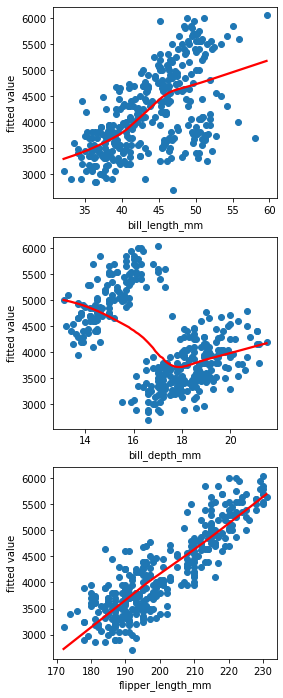

In [54]:
# 조금 smooth한 선으로 보기 좋게 나타내볼게요 
plt.figure(figsize=(4,12))
cnt=1
for i in range(2,5):
    plt.subplot(3,1,cnt)
    plt.scatter(df.iloc[:,i],df['body_mass_g'])
    sns.regplot(df.iloc[:,i],fitted,lowess=True,scatter=False,color='red')
    plt.xlabel(df.columns[i])
    plt.ylabel('fitted value')
    cnt+=1

In [55]:
# 아까 고려하지 않았던 성별을 독립변수로 넣어 사용해볼게요 
# 결측치 체크를 안 한 species, island, sex 를 사용할 것이기 때문에 결측치 체크 한 번 할게요
df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  9
dtype: int64

In [56]:
# 결측치 제거
df = df.dropna()
df.isnull().sum()

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [57]:
reg3  = ols('body_mass_g ~ bill_length_mm+bill_depth_mm+flipper_length_mm+sex',data=df).fit()
reg3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     380.4
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          1.34e-121
Time:                        03:20:01   Log-Likelihood:                -2401.5
No. Observations:                 332   AIC:                             4813.
Df Residuals:                     327   BIC:                             4832.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2308.9902    625.898     -3.689      0.000   -3540.284   -1077.696
sex[T.MALE]         533.2092     51.325     10.389      0.000     432.240     634.179
bill_length_mm       -2.2999      4.642     -0.495      0.621     -11.431       6.832
bill_depth_mm       -84.1979     15.445     -5.451      0.000    -114.582     -53.814
flipper_length_mm    38.7664      2.426     15.982      0.000      33.994      43.538
==============================================================================
Omnibus:                        3.188   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.383
Skew:                           0.028   Prob(JB):                        0.304
Kurtosis:                       2.589   Cond. No.                     7.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  7e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

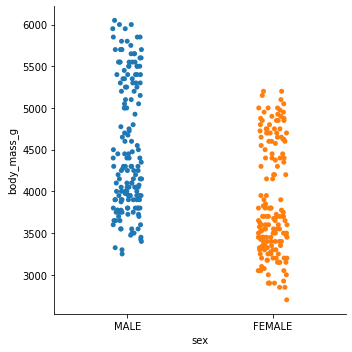

In [58]:
# 보시면 sex[T.MALE]이라고 돼있는데 sex == MALE일 경우 533.2092 를 더하라는 이야기입니다 
# 실제로 수컷 펭귄의 몸무게가 더 많이 나가는 걸로 확인할 수 있어요 
sns.catplot('sex','body_mass_g',data=df)

In [59]:
# 이번에는 펭귄의 종과 펭귄이 사는 섬도 같이 고려해볼게요
reg4  = ols('body_mass_g ~ bill_length_mm+bill_depth_mm+flipper_length_mm+sex+species+island',data=df).fit()
reg4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            body_mass_g   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     286.9
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          8.27e-142
Time:                        03:20:01   Log-Likelihood:                -2341.7
No. Observations:                 332   AIC:                             4701.
Df Residuals:                     323   BIC:                             4736.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept            -1517.4747    567.577     -2.674      0.008   -2634.089    -400.861
sex[T.MALE]            379.0453     47.514      7.978      0.000     285.570     472.521
species[T.Chinstrap]  -260.1579     87.279     -2.981      0.003    -431.864     -88.452
species[T.Gentoo]      991.2294    135.271      7.328      0.000     725.106    1257.353
island[T.Dream]        -12.5917     57.700     -0.218      0.827    -126.107     100.924
island[T.Torgersen]    -48.0260     60.046     -0.800      0.424    -166.158      70.106
bill_length_mm          18.1922      7.034      2.586      0.010       4.354      32.030
bill_depth_mm           69.9200     19.550      3.576      0.000      31.459     108.381
flipper_length_mm       16.1238      2.897      5.565      0.000      10.424      21.824
==============================================================================
Omnibus:                        0.650   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.722   Jarque-Bera (JB):                0.770
Skew:                           0.071   Prob(JB):                        0.680
Kurtosis:                       2.812   Cond. No.                     7.58e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
# 아까 sex와 달리 species와 island는 각 세 개의 범주를 가지고 있어요.
# 해석하시는 법은 다음과 같습니다. 
# 1.species가 Adelie일 때를 기본으로 둔다. 
# 2.species가 Chinstrap일 때 -260.1579를 더한다. (specied==Chinstrap일 때 1, 아니면 0인 변수가 생긴 것)
# 3.species가 Gentoo일 때 991.2294를 더한다.
# island도 같은 방식으로 해석하시면 돼요! 범주가 n개일 때 n-1개 변수가 생긴답니다.

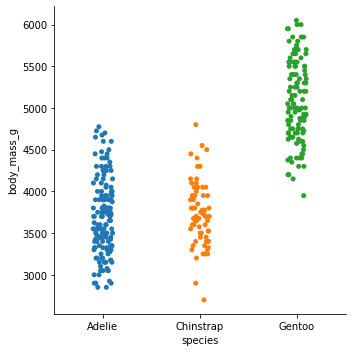

In [61]:
sns.catplot('species','body_mass_g',data=df)

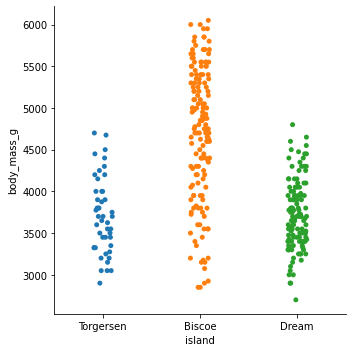

In [62]:
sns.catplot('island','body_mass_g',data=df)

In [63]:
# 회귀분석시 변수선택을 해주시는 것이 좋아요. 
# Forward Addition, Backward Elimination, stepwise selection 세 가지 방법을 써볼게요.
# R의 stepAIC 라이브러리처럼 aic를 단순 비교하며 aic가 다음 스텝에서 작아질 때 다음으로 넘어가겠습니다.
# Forward Addition
var_list = df.columns.tolist()
var_list.remove('body_mass_g')
aic_list, select_list = [],[]
original = float('inf')
stop = 1

while stop==1 and len(var_list)!=0:
    stop = 0
    aic_list = []
    for i in range(len(var_list)):
        try_list = select_list + [var_list[i]]
        reg = ols(f'body_mass_g ~ {"+".join(try_list)}',data=df).fit()
        aic_list.append(reg.aic)
    min_aic = min(aic_list)
    min_aic_idx = aic_list.index(min_aic)
    if original >= min_aic:
        select_list.append(var_list[min_aic_idx])
        del var_list[min_aic_idx]
        original = min_aic 
        stop = 1
    
print(select_list)

['flipper_length_mm', 'sex', 'species', 'bill_depth_mm', 'bill_length_mm']


In [64]:
# Backward Elimination
select_list = df.columns.tolist()
select_list.remove('body_mass_g')
aic_list = []
original = float('inf')
stop = 1

while stop==1 and len(var_list)!=0:
    stop = 0
    aic_list = []
    for i in range(len(select_list)):
        try_list = select_list.copy()
        try_list.remove(select_list[i])
        reg = ols(f'body_mass_g ~ {"+".join(try_list)}',data=df).fit()
        aic_list.append(reg.aic)
    min_aic = min(aic_list)
    min_aic_idx = aic_list.index(min_aic)
    if original >= min_aic:
        select_list.remove(select_list[min_aic_idx])
        original = min_aic 
        stop = 1
    
print(select_list)

['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex']


In [65]:
# Stepwise Selection
var_list = df.columns.tolist()
var_list.remove('body_mass_g')
aic_list, select_list = [],[]
original = float('inf')
stop = 1

while stop==1 and len(var_list)!=0:
    stop = 0
    aic_list = []
    for i in range(len(var_list)):
        try_list = select_list + [var_list[i]]
        reg = ols(f'body_mass_g ~ {"+".join(try_list)}',data=df).fit()
        aic_list.append(reg.aic)
    if len(select_list) > 1:
        for j in range(len(select_list)):
            try_list = select_list.copy()
            try_list.remove(select_list[j])
            reg = ols(f'body_mass_g ~ {"+".join(try_list)}',data=df).fit()
            aic_list.append(reg.aic)
    min_aic = min(aic_list)
    min_aic_idx = aic_list.index(min_aic)
    add = var_list + select_list
    min_aic_var = add[min_aic_idx]
    if original >= min_aic:
        if min_aic_idx < len(var_list):
            select_list.append(min_aic_var)
            var_list.remove(min_aic_var)
        else:
            select_list.remove(min_aic_var)
            var_list.append(min_aic_var)
        original = min_aic 
        stop = 1
    
print(select_list)

['flipper_length_mm', 'sex', 'species', 'bill_depth_mm', 'bill_length_mm']


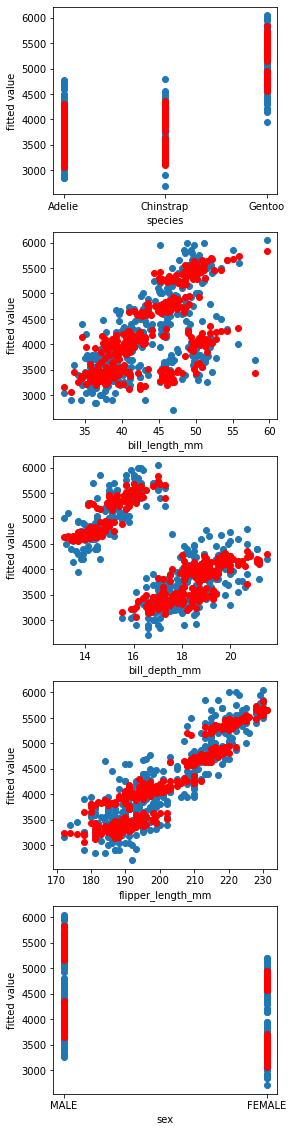

In [66]:
# 세 가지 변수선택법 모두에서 island만 사용하지 않는 변수 조합이 선택됐습니다.
# plot을 그려 추정값들의 분포를 확인하겠습니다.
plt.figure(figsize=(4,20))
reg = ols('body_mass_g~flipper_length_mm+sex+species+bill_depth_mm+bill_length_mm', data=df).fit()
fitted = reg.predict(df.iloc[:,[0,2,3,4,6]])
cnt=1
for i in [0,2,3,4,6]:
    plt.subplot(5,1,cnt)
    plt.scatter(df.iloc[:,i],df['body_mass_g'])
    plt.scatter(df.iloc[:,i],fitted,color='red')
    plt.xlabel(df.columns[i])
    plt.ylabel('fitted value')
    cnt+=1 
# 아까보다 낫네요

In [67]:
# 로지스틱 회귀분석 - 종속변수가 범주형인 경우에 사용, classification의 일종
# 종속변수를 반드시 LabelEncoder를 통해 수치형으로 바꿔줘야 합니다.
# 독립변수는 바꾸지 마세요! 
df1 = df.copy()
df1.loc[:,'sex'] = classle.fit_transform(df1.loc[:,'sex'])

In [68]:
# 이항 로지스틱 회귀(종속변수의 범주가 두 가지인 경우)
import statsmodels.api as sm

logis = sm.Logit.from_formula('sex ~ species+bill_length_mm+island+bill_depth_mm+flipper_length_mm+body_mass_g', df1).fit()
logis.summary()

Optimization terminated successfully.
         Current function value: 0.189830
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                  332
Model:                          Logit   Df Residuals:                      323
Method:                           MLE   Df Model:                            8
Date:                Mon, 05 Oct 2020   Pseudo R-squ.:                  0.7261
Time:                        03:20:11   Log-Likelihood:                -63.024
converged:                       True   LL-Null:                       -230.12
                                        LLR p-value:                 2.138e-67
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -80.3756     12.330     -6.518      0.000    -104.543     -56.208
species[T.Chinstrap]    -7.4026      1.663     -4.452      0.000     -10.661      -4.144
species[T.Gentoo]       -8.4273      2.597     -3.245      0.001     -13.518      -3.337
island[T.Dream]          0.3241      0.809      0.401      0.689      -1.262       1.910
island[T.Torgersen]     -0.5079      0.856     -0.593      0.553      -2.185       1.169
bill_length_mm           0.6144      0.132      4.656      0.000       0.356       0.873
bill_depth_mm            1.6464      0.336      4.903      0.000       0.988       2.305
flipper_length_mm        0.0267      0.048      0.552      0.581      -0.068       0.121
body_mass_g              0.0058      0.001      5.351      0.000       0.004       0.008
========================================================================================
"""

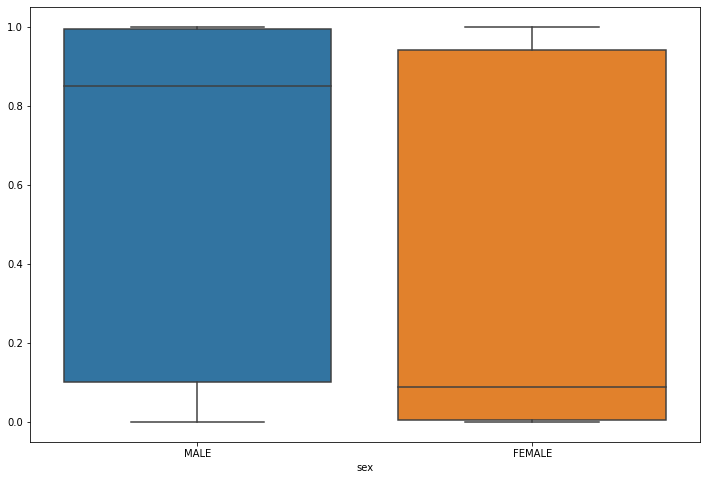

In [69]:
# 로지스틱 회귀분석을 통해 예측한 확률과 실제 분포를 그려보겠습니다.
prob = logis.predict()
plt.figure(figsize=(12, 8))
sns.boxplot(df['sex'], prob)
plt.show()
# 별로네요 

In [70]:
# 변수 선택 후 다시 해보겠습니다.
# Stepwise Selection
var_list = df1.columns.tolist()
var_list.remove('sex')
aic_list, select_list = [],[]
original = float('inf')
stop = 1

while stop==1 and len(var_list)!=0:
    stop = 0
    aic_list = []
    for i in range(len(var_list)):
        try_list = select_list + [var_list[i]]
        reg = sm.Logit.from_formula(f'sex ~ {"+".join(try_list)}',data=df1).fit()
        aic_list.append(reg.aic)
    if len(select_list) > 1:
        for j in range(len(select_list)):
            try_list = select_list.copy()
            try_list.remove(select_list[j])
            reg = sm.Logit.from_formula(f'sex ~ {"+".join(try_list)}',data=df1).fit()
            aic_list.append(reg.aic)
    min_aic = min(aic_list)
    min_aic_idx = aic_list.index(min_aic)
    add = var_list + select_list
    min_aic_var = add[min_aic_idx]
    if original >= min_aic:
        if min_aic_idx < len(var_list):
            select_list.append(min_aic_var)
            var_list.remove(min_aic_var)
        else:
            select_list.remove(min_aic_var)
            var_list.append(min_aic_var)
        original = min_aic 
        stop = 1
    
print(select_list)

Optimization terminated successfully.
         Current function value: 0.693096
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.693066
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.631987
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618237
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660634
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.597149
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.319417
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.520346
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.589142
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.247495
  

In [71]:
logis2 = sm.Logit.from_formula('sex ~ species+bill_length_mm+bill_depth_mm+body_mass_g', df1).fit()
logis2.summary()

Optimization terminated successfully.
         Current function value: 0.191713
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    sex   No. Observations:                  332
Model:                          Logit   Df Residuals:                      326
Method:                           MLE   Df Model:                            5
Date:                Mon, 05 Oct 2020   Pseudo R-squ.:                  0.7234
Time:                        03:20:13   Log-Likelihood:                -63.649
converged:                       True   LL-Null:                       -230.12
                                        LLR p-value:                 8.226e-70
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -76.0929      9.804     -7.762      0.000     -95.308     -56.878
species[T.Chinstrap]    -6.8976      1.558     -4.427      0.000      -9.952      -3.844
species[T.Gentoo]       -7.8750      2.249     -3.501      0.000     -12.283      -3.467
bill_length_mm           0.6201      0.131      4.743      0.000       0.364       0.876
bill_depth_mm            1.6436      0.331      4.970      0.000       0.995       2.292
body_mass_g              0.0060      0.001      5.622      0.000       0.004       0.008
========================================================================================
"""

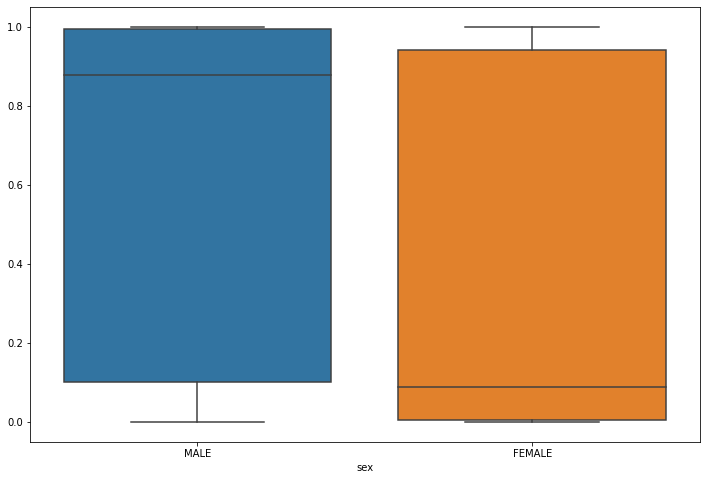

In [72]:
prob = logis2.predict()
plt.figure(figsize=(12, 8))
sns.boxplot(df['sex'], prob)
plt.show()
# 여전히 별로네요..

In [73]:
print(logis.aic, logis2.aic) # aic가 감소한 것으로 성능이 조금 향상된 걸 확인할 수 있습니다.

144.04715870540716 139.29736695169396
